<a href="https://colab.research.google.com/github/meenanagarajan/Heart-Disease-Predictor/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import ADASYN
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as skPCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, recall_score, precision_score
from tabulate import tabulate
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

In [ ]:
filepath = "/content/drive/MyDrive/colab_mount/heart_2020_cleaned.csv"
df = pd.read_csv(filepath)
df.head(10)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
5,Yes,28.87,Yes,No,No,6.0,0.0,Yes,Female,75-79,Black,No,No,Fair,12.0,No,No,No
6,No,21.63,No,No,No,15.0,0.0,No,Female,70-74,White,No,Yes,Fair,4.0,Yes,No,Yes
7,No,31.64,Yes,No,No,5.0,0.0,Yes,Female,80 or older,White,Yes,No,Good,9.0,Yes,No,No
8,No,26.45,No,No,No,0.0,0.0,No,Female,80 or older,White,"No, borderline diabetes",No,Fair,5.0,No,Yes,No
9,No,40.69,No,No,No,0.0,0.0,Yes,Male,65-69,White,No,Yes,Good,10.0,No,No,No


In [ ]:
# Drop Duplicate Columns
pre = df.shape
df_drop = df.drop_duplicates()
print(f'{pre[0] - df_drop.shape[0]} rows dropped')

18078 rows dropped


In [ ]:
# Encode Discrete Variables (Label Encoding)
cols = df.select_dtypes(include='object').columns
defined_categories = {"AgeCategory": {'18-24': 0, '25-29': 1, '30-34': 2, '35-39': 3, '40-44': 4, '45-49': 5, '50-54': 6, '55-59': 7, '60-64': 8, '65-69': 9, '70-74': 10, '75-79': 11, '80 or older': 12},
                      "Race": {'White': 0, 'Black': 1, 'Asian': 2, 'American Indian/Alaskan Native': 3, 'Other': 4, 'Hispanic': 5},
                      "Diabetic": {'Yes': 0, 'No': 1, 'No, borderline diabetes': 2, 'Yes (during pregnancy)': 3},
                      "GenHealth": {'Very good': 4, 'Fair': 1, 'Good': 2, 'Poor': 0, 'Excellent': 5}}
df_drop = df_drop.replace(defined_categories)

## Mute Warnings
pd.options.mode.chained_assignment = None

le = LabelEncoder()
for col in cols:
  if col not in defined_categories.keys():
    df_drop[col] = le.fit_transform(df_drop[col])

## Unmute Warnings
pd.options.mode.chained_assignment = 'warn'

In [ ]:
df_drop_unsupervised = df_drop.drop(columns=['PhysicalHealth', 'MentalHealth', 'GenHealth', 'Race', 'SleepTime'])
df_drop_unsupervised

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,0,0,7,0,1,1,0,1
1,0,20.34,0,0,1,0,0,12,1,1,0,0,0
2,0,26.58,1,0,0,0,1,9,0,1,1,0,0
3,0,24.21,0,0,0,0,0,11,1,0,0,0,1
4,0,23.71,0,0,0,1,0,4,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,27.41,1,0,0,1,1,8,0,0,1,0,0
319791,0,29.84,1,0,0,0,1,3,1,1,1,0,0
319792,0,24.24,0,0,0,0,0,5,1,1,0,0,0
319793,0,32.81,0,0,0,0,0,1,1,0,0,0,0


In [ ]:
x = df_drop_unsupervised.drop("HeartDisease", axis=1)
y = df_drop_unsupervised["HeartDisease"]

In [ ]:
# SMOTE-NC Upsampling Minority Class
ret = []
for c in x.columns:
  if c in df.select_dtypes(include='object').columns:
    ret.append(True)
  else:
    ret.append(False)
xsmotenc, ysmotenc = SMOTENC(categorical_features=ret).fit_resample(x, y)

In [ ]:
smotenc_combined = pd.concat([pd.DataFrame(xsmotenc), pd.DataFrame(ysmotenc)], axis=1)

In [ ]:
# Downsample Majority Class
df_majority = df_drop_unsupervised[df_drop_unsupervised['HeartDisease'] == 0]
df_minority = df_drop_unsupervised[df_drop_unsupervised['HeartDisease'] == 1]
maj_downsample = resample(df_majority,
             replace=True,
             n_samples=len(df_minority))

In [ ]:
ds_combined = pd.concat([maj_downsample, df_minority], axis=0)

In [ ]:
pca_3 = skPCA(n_components=3)
pca_2 = skPCA(n_components=2)
df_drop_pca3D_un, df_drop_pca2D_un = pca_3.fit_transform(df_drop_unsupervised), pca_2.fit_transform(df_drop_unsupervised)
smotenc_pca3D, smotenc_pca2D = pca_3.fit_transform(smotenc_combined), pca_2.fit_transform(smotenc_combined)
ds_pca3D, ds_pca2D = pca_3.fit_transform(ds_combined), pca_2.fit_transform(ds_combined)

In [ ]:
pca_ = skPCA(n_components=3)
for data in [df_drop_unsupervised, smotenc_combined, ds_combined]:
  pca_.fit(data)
  print(pca_.explained_variance_ratio_.cumsum())

[0.74599931 0.97563798 0.98049552]
[0.76079005 0.96926908 0.97503937]
[0.76099316 0.96889149 0.9747163 ]


In [ ]:
def cmatrix(model_name, actual, predicted, color, model):
    cm = confusion_matrix(actual, predicted)
    print(cm)
    ax = sns.heatmap(cm / np.sum(cm), annot=True, fmt='.2%', cmap=color)

    ax.set_title(f'{model} with {model_name} Dataset \n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()

In [ ]:
gmm = GaussianMixture(n_components=2)
labels = gmm.fit_predict(ds_pca3D)
print(labels)

[1 1 1 ... 0 0 0]


In [ ]:
np.count_nonzero(labels), labels.size - np.count_nonzero(labels)

(34983, 19539)

In [ ]:
sample_indices = np.random.choice(ds_pca3D.shape[0], size=2000, replace=False)
temp = ds_pca3D[sample_indices, :]
temp2 = labels[sample_indices]
fig = px.scatter_3d(
    x=temp[:, 0],
    y=temp[:, 1],
    z=temp[:, 2],
    color=temp2,
    opacity=0.7,
    size_max=20
)
fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    title='GMM',
    width=800,
    height=800,
)
fig.show()

In [ ]:
c = np.where(labels == ds_combined['HeartDisease'])
print(np.count_nonzero(c) / labels.shape[0]*100)

31.513884303583872


In [ ]:
silhouette_score(ds_pca3D, labels)

0.2501517693346755

In [ ]:
temp_df = ds_combined
temp_df['cluster'] = labels
cluster_features = temp_df.groupby('cluster').mean()

In [ ]:
cluster_features.to_markdown()

'|   cluster |   HeartDisease |     BMI |   Smoking |   AlcoholDrinking |    Stroke |   DiffWalking |      Sex |   AgeCategory |   Diabetic |   PhysicalActivity |   Asthma |   KidneyDisease |   SkinCancer |\n|----------:|---------------:|--------:|----------:|------------------:|----------:|--------------:|---------:|--------------:|-----------:|-------------------:|---------:|----------------:|-------------:|\n|         0 |       0.75792  | 33.5886 |  0.662009 |         0.0390501 | 0.164492  |      0.483034 | 0.589692 |       9.02068 |   0.57746  |           0.513281 | 0.204975 |       0.143047  |     0.165566 |\n|         1 |       0.355944 | 26.2326 |  0.402367 |         0.0681188 | 0.0561701 |      0.115656 | 0.481748 |       7.02747 |   0.950748 |           0.814453 | 0.13215  |       0.0429351 |     0.120459 |'

In [ ]:
gmm2 = GaussianMixture(n_components=2)
labels = gmm2.fit_predict(ds_pca2D)
print(labels)

[0 0 0 ... 1 1 0]


In [ ]:
sample_indices = np.random.choice(ds_pca2D.shape[0], size=2000, replace=False)
temp = ds_pca2D[sample_indices, :]
temp2 = labels[sample_indices]
fig = px.scatter(
    x=temp[:, 0],
    y=temp[:, 1],
    color=temp2,
    opacity=0.7,
    size_max=10
)
fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
    ),
    width=800,
    height=800,
    title='GMM',
)

In [ ]:
c = np.where(labels == ds_combined['HeartDisease'])
print(np.count_nonzero(c) / labels.shape[0]*100)

56.44510472836654


In [ ]:
silhouette_score(ds_pca2D, labels)

0.4072561900000464

In [ ]:
temp_df = ds_combined
temp_df['cluster'] = labels
cluster_features = temp_df.groupby('cluster').mean()

In [ ]:
cluster_features

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,Asthma,KidneyDisease,SkinCancer
cluster,,,,,,,,,,,,,
0,0.456900,26.289727,0.486966,0.064276,0.086397,0.192265,0.527675,7.451357,0.870295,0.750178,0.142556,0.065503,0.135076
1,0.627865,36.519933,0.520480,0.038196,0.120480,0.410622,0.498945,8.603347,0.658785,0.577010,0.204802,0.118298,0.141215


In [ ]:
v1 = np.array(cluster_features.iloc[0])
v2 = np.array(cluster_features.iloc[1])
np.abs(v1 - v2) / (v1 + v2) * 100.0

array([15.76056101, 16.287632  ,  3.32667832, 25.451526  , 16.47522193,
       36.21851045,  2.79848866,  7.17540034, 13.83247309, 13.04773886,
       17.91983068, 28.72410275,  2.2218742 ])

In [ ]:
logistic_regression = LogisticRegression(solver='sag', max_iter=200)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
logistic_regression.fit(X_train, y_train)
y1 = logistic_regression.predict(X_train)
y2 = logistic_regression.predict(X_test)
print(accuracy_score(y_train, y1))
print(accuracy_score(y_test, y2))

0.9107936678916034
0.9080107384329842


In [ ]:
x_ds, y_ds = ds_combined.drop("HeartDisease", axis=1), ds_combined["HeartDisease"]

In [ ]:
logistic_regression = LogisticRegression(solver='sag', max_iter=200)
X_train, X_test, y_train, y_test = train_test_split(x_ds, y_ds, test_size=0.2)
logistic_regression.fit(X_train, y_train)
y1 = logistic_regression.predict(X_train)
y2 = logistic_regression.predict(X_test)
print(accuracy_score(y_train, y1))
print(accuracy_score(y_test, y2))

0.7426462159249834
0.7391104997707474


In [ ]:
x = df_drop.drop("HeartDisease", axis=1)
y = df_drop["HeartDisease"]
# SMOTE-NC Upsampling Minority Class
ret = []
for c in x.columns:
  if c in df.select_dtypes(include='object').columns:
    ret.append(True)
  else:
    ret.append(False)
xsmotenc, ysmotenc = SMOTENC(categorical_features=ret).fit_resample(x, y)
smotenc_combined = pd.concat([pd.DataFrame(xsmotenc), pd.DataFrame(ysmotenc)], axis=1)
# Downsample Majority Class
df_majority = df_drop[df_drop['HeartDisease'] == 0]
df_minority = df_drop[df_drop['HeartDisease'] == 1]
maj_downsample = resample(df_majority,
             replace=True,
             n_samples=len(df_minority))
ds_combined = pd.concat([maj_downsample, df_minority], axis=0)

In [ ]:
x_ds, y_ds = ds_combined.drop("HeartDisease", axis=1), ds_combined["HeartDisease"]

In [ ]:
from xgboost import XGBClassifier

0.9128527217211536
0.9098667638870476
[[54434   335]
 [ 5104   471]]


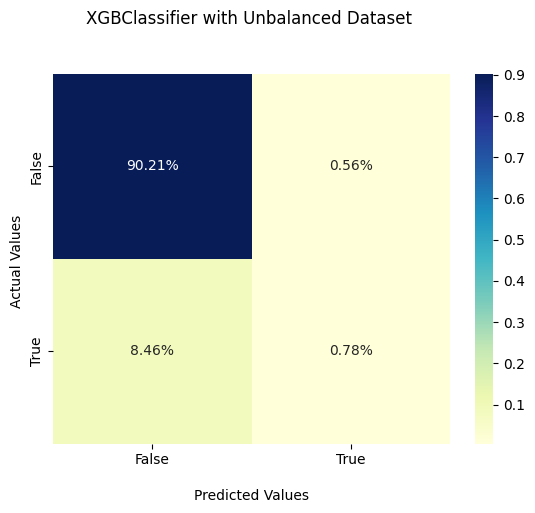

In [ ]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=4)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
xgb.fit(X_train, y_train)
y1 = xgb.predict(X_train)
y2 = xgb.predict(X_test)
print(accuracy_score(y_train, y1))
print(accuracy_score(y_test, y2))
cmatrix("Unbalanced", y_test, y2, 'YlGnBu', "XGBClassifier")

0.771694522777816
0.7634112792297112
[[3962 1536]
 [1044 4363]]


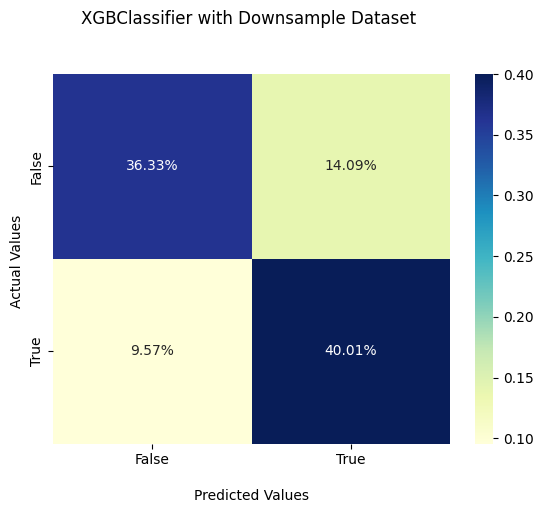

In [ ]:
xgb2 = XGBClassifier(learning_rate=.2, n_estimators=100, max_depth=4)
X_train, X_test, y_train, y_test = train_test_split(x_ds, y_ds, test_size=0.2)
xgb2.fit(X_train, y_train)
y1 = xgb2.predict(X_train)
y2 = xgb2.predict(X_test)
# X_train, X_test, y_train, y_test = train_test_split(x_ds, y_ds, test_size=0.2)
# # Define the hyperparameters to search over
# param_grid = {
#     'learning_rate': [0.1, .2, .3, .35, .4, .45, .5],
#     'max_depth': [4, 5, 6, 7, 8, 9, 10],
#     'n_estimators': [100, 200, 300, 400, 500]
# }
# # Define the XGBoost Classifier model
# xgb = XGBClassifier()
# # Define the GridSearchCV object
# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1)
# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters and the corresponding accuracy score
# print("Best hyperparameters: ", grid_search.best_params_)
# print("Best accuracy score: ", grid_search.best_score_)
print(accuracy_score(y_train, y1))
print(accuracy_score(y_test, y2))
cmatrix("Downsample", y_test, y2, 'YlGnBu', "XGBClassifier")

0.944294273436735
0.9319657870526402
[[52686  1982]
 [ 5487 49628]]


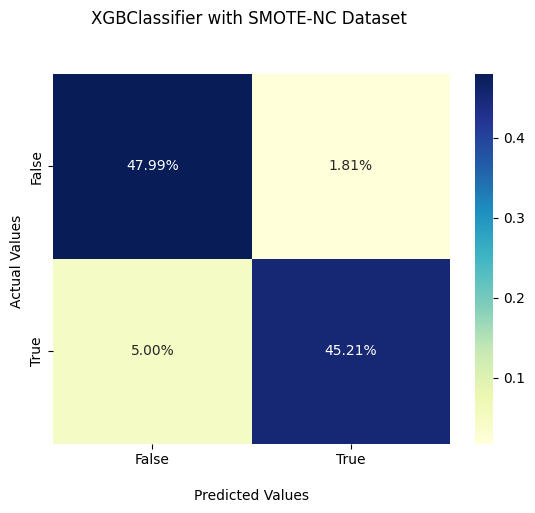

In [ ]:
xgb = XGBClassifier(learning_rate=0.30, n_estimators=900, max_depth=5)
X_train, X_test, y_train, y_test = train_test_split(xsmotenc, ysmotenc, test_size=0.2)
xgb.fit(X_train, y_train)
y1 = xgb.predict(X_train)
y2 = xgb.predict(X_test)
print(accuracy_score(y_train, y1))
print(accuracy_score(y_test, y2))
cmatrix("SMOTE-NC", y_test, y2, 'YlGnBu', "XGBClassifier")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
y1 = xgb.predict(X_train)
y2 = xgb.predict(X_test)
print(accuracy_score(y_train, y1))
print(accuracy_score(y_test, y2))

0.910147365281121
0.9118719342436696


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

## Training

### Unsampled recall: 0.02798887859128823

In [ ]:
clf = RandomForestClassifier(max_depth=8, oob_score=True)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
clf.fit(X_train, y_train)
y1 = clf.predict(X_train)
y2 = clf.predict(X_test)

train accuracy: 0.9120241286307913
test accuracy: 0.911606787750232
recall 0.03269905782375762
[[54833    98]
 [ 5236   177]]


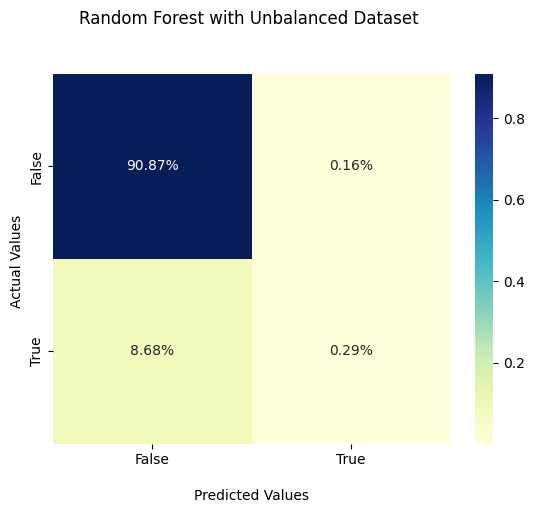

In [ ]:
print(f'train accuracy: {accuracy_score(y_train, y1)}')
print(f'test accuracy: {accuracy_score(y_test, y2)}')
print(f'recall {recall_score(y_test, y2)}') # High recall important bc means low amount of false negatives

cmatrix("Unbalanced", y_test, y2, 'YlGnBu', "Random Forest")

labels = clf.feature_names_in_
values = clf.feature_importances_

sorted_inds = np.argsort(-values)

sorted_labels = labels[sorted_inds]
sorted_values = values[sorted_inds]

### Downsampled recall: 0.7902456912357902

In [ ]:
clf_1 = RandomForestClassifier(max_depth=8, oob_score=True)
X_train_ds, X_test_ds, y_train_ds, y_test_ds = train_test_split(x_ds, y_ds, test_size=0.2)
clf_1.fit(X_train_ds, y_train_ds)
y1_ds = clf_1.predict(X_train_ds)
y2_ds = clf_1.predict(X_test_ds)


train accuracy: 0.7674759841346264
test accuracy: 0.7624942686840899
recall 0.8211058908565233
[[3771 1600]
 [ 990 4544]]


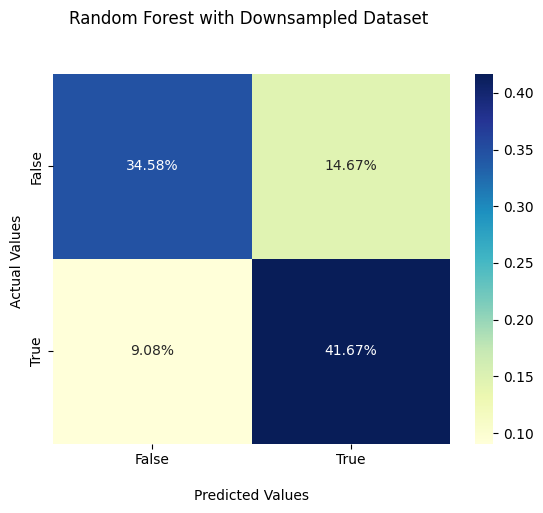

In [ ]:
print(f'train accuracy: {accuracy_score(y_train_ds, y1_ds)}')
print(f'test accuracy: {accuracy_score(y_test_ds, y2_ds)}')
print(f'recall {recall_score(y_test_ds, y2_ds)}')

cmatrix("Downsampled", y_test_ds, y2_ds, 'YlGnBu', "Random Forest")


values_ds = clf_1.feature_importances_
sorted_inds = np.argsort(-values_ds)

sorted_values_ds = values_ds[sorted_inds]

### Smote recall: 0.8208625474729769

In [ ]:
clf_2 = RandomForestClassifier(max_depth=8, oob_score=True)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(xsmotenc, ysmotenc, test_size=0.2)
clf_2.fit(X_train_smote, y_train_smote)
y1_smote = clf_2.predict(X_train_smote)
y2_smote = clf_2.predict(X_test_smote)


train accuracy: 0.8036385663438306
test accuracy: 0.8013900148474719
recall 0.8567397833803586
[[3771 1600]
 [ 990 4544]]


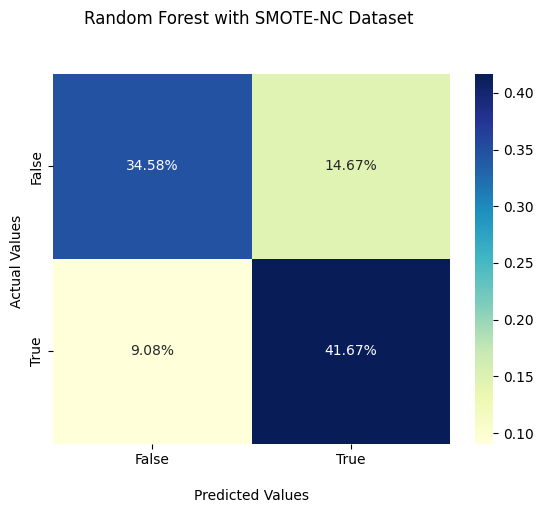

In [ ]:
print(f'train accuracy: {accuracy_score(y_train_smote, y1_smote)}')
print(f'test accuracy: {accuracy_score(y_test_smote, y2_smote)}')
print(f'recall {recall_score(y_test_smote, y2_smote)}')

cmatrix("SMOTE-NC", y_test_ds, y2_ds, 'YlGnBu', "Random Forest")

values_smote = clf_2.feature_importances_
sorted_inds = np.argsort(-values_smote)

sorted_values_smote = values_smote[sorted_inds]

## Analysis of important features

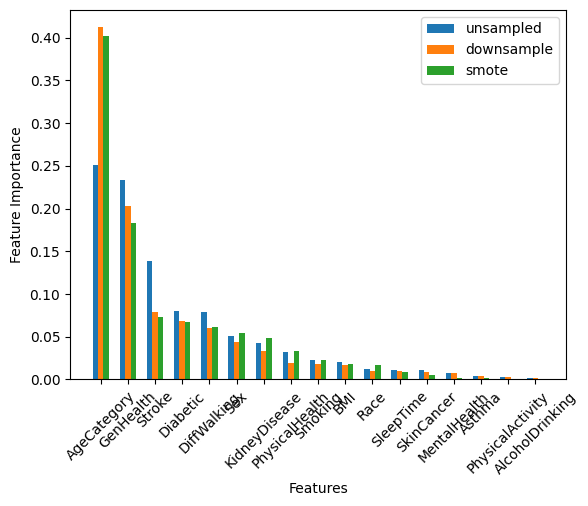

In [ ]:
x_axis = np.arange(len(sorted_labels))
width = 0.2

plt.bar(x_axis - width, sorted_values, width, label="unsampled")
plt.bar(x_axis, sorted_values_ds, width, label="downsample")
plt.bar(x_axis + width, sorted_values_smote, width, label="smote")


plt.xticks(x_axis, sorted_labels)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.legend()
plt.show()

## Featue selected samples - RF

In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
model_unsampled = SelectFromModel(clf, prefit=True)
X_fs_transform = model_unsampled.transform(x)
feature_idx = model_unsampled.get_support()
feat_names = x.columns[feature_idx]


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SelectFromModel was fitted without feature names



In [ ]:
model_ds = SelectFromModel(clf_1, prefit=True)
X_fs_transform = model_ds.transform(x_ds)
feature_idx_ds = model_ds.get_support()
feat_names_ds = x_ds.columns[feature_idx_ds]
X_fs_ds = x[feat_names_ds]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SelectFromModel was fitted without feature names



In [ ]:
model_smote = SelectFromModel(clf_2, prefit=True)
X_fs_transform = model_smote.transform(xsmotenc)
feature_idx_smote = model_smote.get_support()
feat_names_smote = xsmotenc.columns[feature_idx_smote]
X_fs_smote = x[feat_names_smote]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but SelectFromModel was fitted without feature names



In [ ]:
X_fs = x[feat_names]
X_fs_ds = x_ds[feat_names_ds]
X_fs_smote = xsmotenc[feat_names_smote]

In [ ]:
print(X_fs)
print(X_fs_ds)
print(X_fs_smote)

        Stroke  DiffWalking  AgeCategory  Diabetic  GenHealth
0            0            0            7         0          4
1            1            0           12         1          4
2            0            0            9         0          1
3            0            0           11         1          2
4            0            1            4         1          4
...        ...          ...          ...       ...        ...
319790       0            1            8         0          1
319791       0            0            3         1          4
319792       0            0            5         1          2
319793       0            0            1         1          2
319794       0            0           12         1          2

[301717 rows x 5 columns]
        Stroke  DiffWalking  AgeCategory  Diabetic  GenHealth
242480       0            0            6         1          5
125399       0            1            7         1          4
313882       0            0            0   

## FS analysis

Smote has the highest recall score, and does not identify having a stroke as a significant feature for classifying heart diesase. Worth running models on smote data and unsampled data to compare both accuracy and recall

# MLP

## Defining the model

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
scalar = StandardScaler()
alphas = np.arange(1e-3, 1e-5, -5e-5)

def run_nn(x_data, y_data):

  recall = []
  accuracy = []
  precision = []

  X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

  scalar.fit(X_train)
  X_train = scalar.transform(X_train)
  X_test = scalar.transform(X_test)

  for alpha in alphas:
    mlp_clf = MLPClassifier(solver="adam", alpha=alpha, hidden_layer_sizes=(15,3))
    mlp_clf.fit(X_train, y_train)
    y1 = mlp_clf.predict(X_train)
    y2 = mlp_clf.predict(X_test)

    accuracy.append(accuracy_score(y_test, y2))
    recall.append(recall_score(y_test, y2))
    precision.append(precision_score(y_test, y2))

  return recall, accuracy, precision


### Raw data

In [ ]:
raw_recall, raw_accuracy, raw_precision = run_nn(x, y)

### Smote sampling

In [ ]:
smote_recall, smote_accuracy, smote_precision = run_nn(xsmotenc, ysmotenc)

### Raw feature selected

In [ ]:
fs_recall, fs_accuracy, fs_precision = run_nn(X_fs, y)

### Smote feature selected (highest recall)

In [ ]:
fs_smote_recall, fs_smote_accuracy, fs_smote_precision = run_nn(X_fs_smote, ysmotenc)


## Analysis

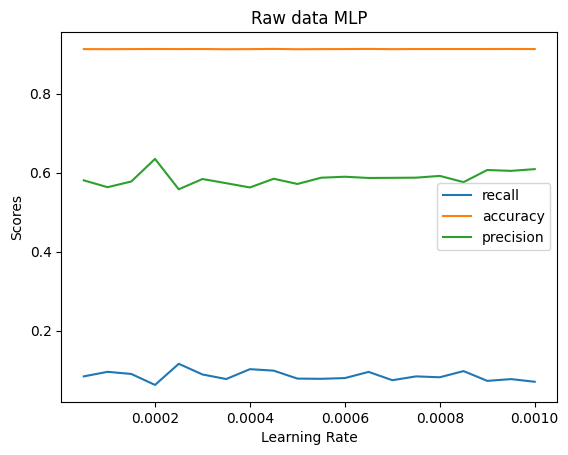

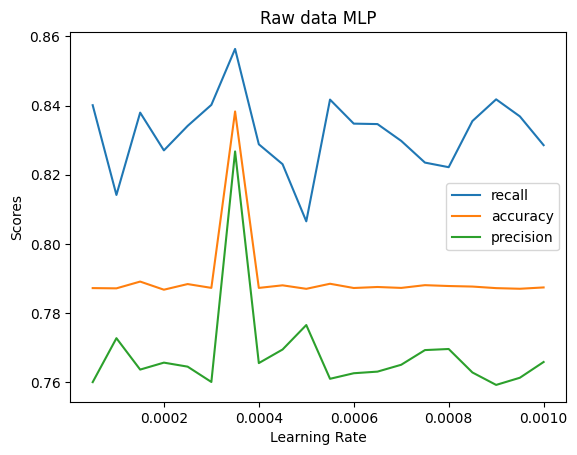

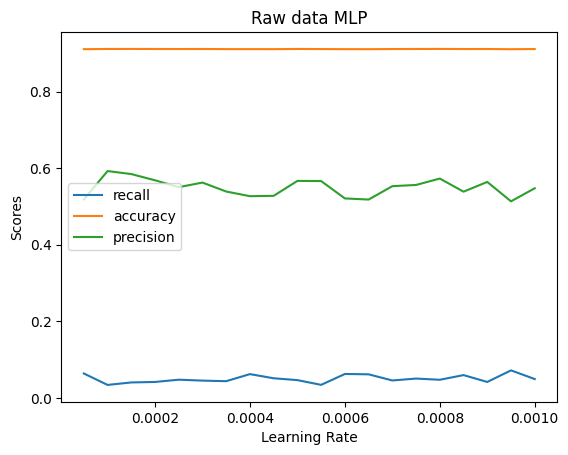

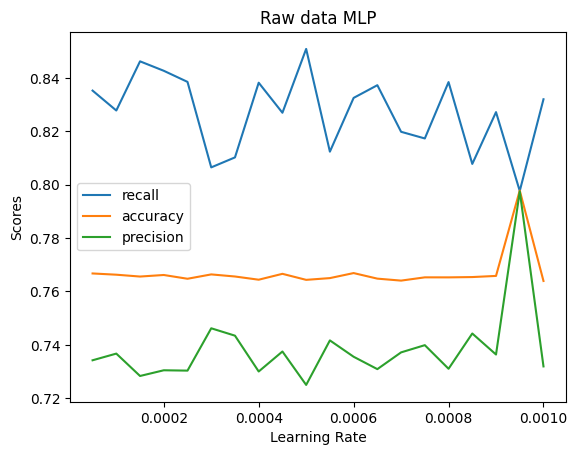

In [ ]:
def plot_rap(recall, accuracy, precision):
  plt.plot(alphas, recall, label="recall")
  plt.plot(alphas, accuracy, label="accuracy")
  plt.plot(alphas, precision, label="precision")

  plt.title("Raw data MLP")
  plt.xlabel("Learning Rate")
  plt.ylabel("Scores")

  plt.legend()
  plt.show()

# Raw data plot
plot_rap(raw_recall, raw_accuracy, raw_precision)

# Smote plot
plot_rap(smote_recall, smote_accuracy, smote_precision)

# Raw data feature extracted
plot_rap(fs_recall, fs_accuracy, fs_precision)

# Smote feature sampled
plot_rap(fs_smote_recall, fs_smote_accuracy, fs_smote_precision)


In [ ]:
def get_max_recall(arr):
  arr = np.array(arr)
  i = np.argmax(arr)
  print(f"max recall learning rate: {alphas[i]}")
  print(f"Recall: {arr[i]}")


In [ ]:
get_max_recall(raw_recall)
get_max_recall(smote_recall)
get_max_recall(fs_recall)
get_max_recall(fs_smote_recall)

max recall learning rate: 0.0002499999999999997
Recall: 0.11579339921685623
max recall learning rate: 0.0003499999999999997
Recall: 0.8563836563836564
max recall learning rate: 0.00095
Recall: 0.07177121771217712
max recall learning rate: 0.0004999999999999998
Recall: 0.8508627923096567


It can be observed that feature extracting smote with MLP classifier yeilds the best results in terms of maximizing recall and accuracy.

In [ ]:
#SVM for Unbalanced

x = df_drop.drop('HeartDisease', axis=1)
y = df_drop['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = svm.SVC(kernel='linear')
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)

y_test_pred = model.predict(X_test)

print("Accuracy for testing set:", accuracy_score(y_train, y_train_pred))
print("Accuracy for testing set:", accuracy_score(y_test, y_test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))
#cmatrix("Downsample", y_test, y2, 'YlGnBu', "XGBClassifier")

In [ ]:
#SVM for downsampled

X = ds_combined.drop('HeartDisease', axis=1)
y = ds_combined['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(x_ds, y_ds, test_size=0.2)
model = svm.SVC(kernel='linear')
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)

y_test_pred = model.predict(X_test)

print("Accuracy for testing set:", accuracy_score(y_train, y_train_pred))
print("Accuracy for testing set:", accuracy_score(y_test, y_test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))
cmatrix("Downsample", y_test, y2, 'YlGnBu', "XGBClassifier")

In [ ]:
#SVM for smotenc

X = smotenc_combined.drop('HeartDisease', axis=1)
y = smotenc_combined['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(xsmotenc, ysmotenc, test_size=0.2)
model = svm.SVC(kernel='linear')
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)

y_test_pred = model.predict(X_test)

print("Accuracy for testing set:", accuracy_score(y_train, y_train_pred))
print("Accuracy for testing set:", accuracy_score(y_test, y_test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))
cmatrix("Downsample", y_test, y2, 'YlGnBu', "XGBClassifier")


Unbalanced
Training set score: 0.8400
Test set score: 0.8391
[[120221  16996]
 [  7273   6369]]


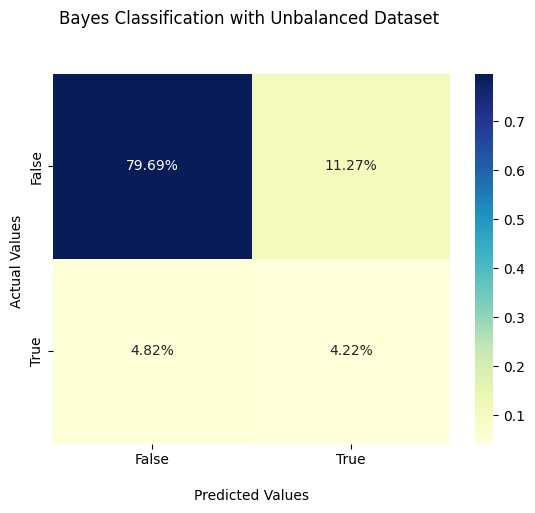


Smotenc
Training set score: 0.7048
Test set score: 0.7039
[[108134  29148]
 [ 52110  85064]]


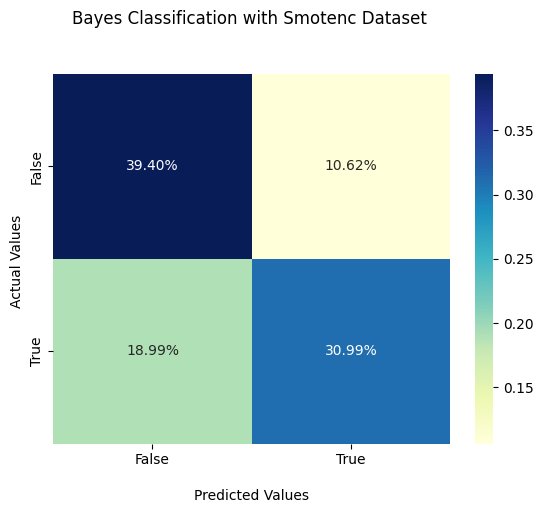


Down Sampled
Training set score: 0.6986
Test set score: 0.6949
[[10949  2676]
 [ 5640  7996]]


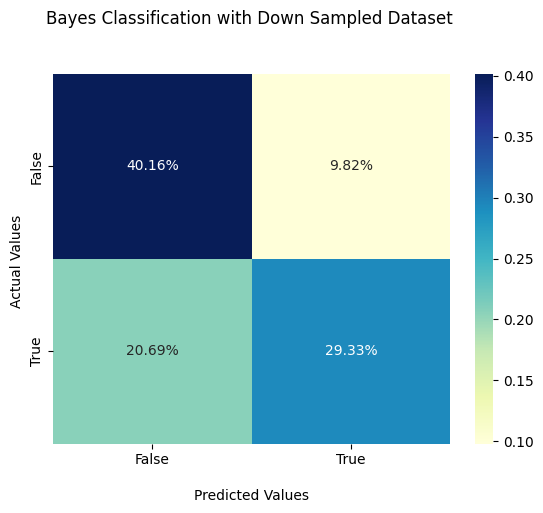

In [ ]:
#Bayes Classification
from sklearn.naive_bayes import *
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


name_df = ['Unbalanced', 'Smotenc', 'Down Sampled']
for i, d in enumerate([df_drop, smotenc_combined, ds_combined]):
  print("\n" + name_df[i])
  X = d.drop('HeartDisease', axis=1)
  y = d['HeartDisease']
  scaler = StandardScaler()
  X = scaler.fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
  gnb = GaussianNB()

  gnb.fit(X_train, y_train)
  y_pred = gnb.predict(X_test)
  y_pred_train = gnb.predict(X_train)
  print('Training set score: {:.4f}'.format(gnb.score(X_train, y_train)))
  print('Test set score: {:.4f}'.format(gnb.score(X_test, y_test)))
  cm = confusion_matrix(y_test, y_pred)
  cmatrix(name_df[i], y_test, y_pred, 'YlGnBu', "Bayes Classification")

n_estimators = 14

Unbalanced
Training set score: 0.9902
Test set score: 0.8983
[[133722   3495]
 [ 11847   1795]]


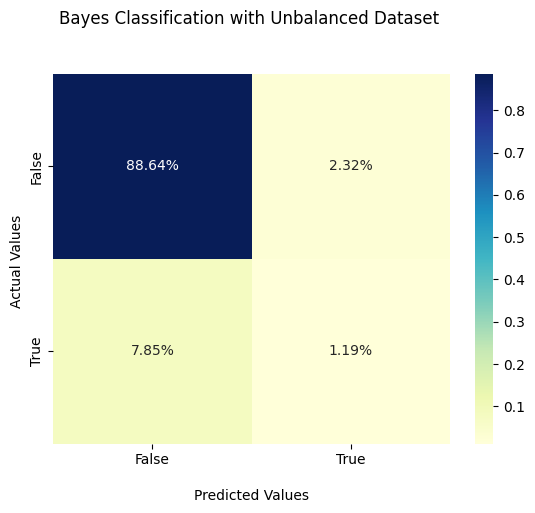


Smotenc
Training set score: 0.9690
Test set score: 0.8094
[[112670  24612]
 [ 27706 109468]]


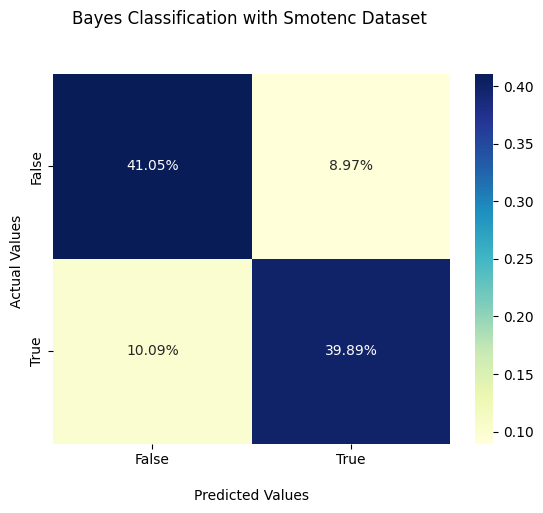


Down Sampled
Training set score: 0.9583
Test set score: 0.6892
[[9506 4119]
 [4354 9282]]


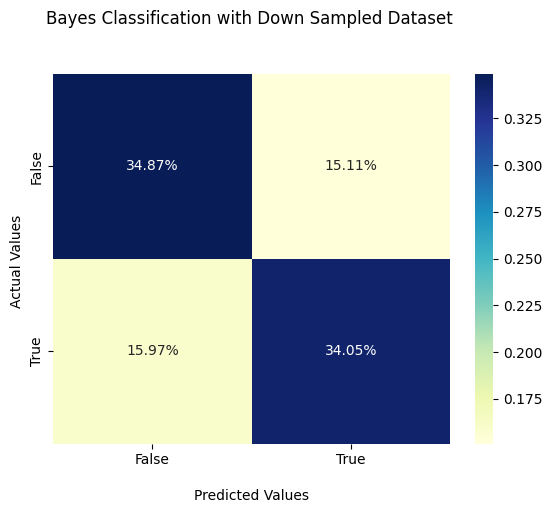

In [ ]:
#decision trees with bagging
from sklearn.ensemble import BaggingClassifier
name_df = ['Unbalanced', 'Smotenc', 'Down Sampled']
n_estimators = 14
print(f"n_estimators = {n_estimators}")
for i, d in enumerate([df_drop, smotenc_combined, ds_combined]):
  print("\n" + name_df[i])
  X = d.drop('HeartDisease', axis=1)
  y = d['HeartDisease']
  scaler = StandardScaler()
  X = scaler.fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
  # Create bagging classifier
  clf = BaggingClassifier(n_estimators = n_estimators, random_state = 22)
  # Fit the model
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  y_pred_train = clf.predict(X_train)
  print('Training set score: {:.4f}'.format(accuracy_score(y_true = y_train, y_pred = clf.predict(X_train))))
  print('Test set score: {:.4f}'.format(accuracy_score(y_true = y_test, y_pred = clf.predict(X_test))))
  cm = confusion_matrix(y_test, y_pred)
  cmatrix(name_df[i], y_test, y_pred, 'YlGnBu', "Bayes Classification")